### Import Required Libraries

In [5]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (Lasso)

In [6]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "lasso": "../results/lasso_results.csv",  # Ensure this file exists
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load LASSO selected features
def load_lasso_features(file_path, num_features=10):
    if os.path.exists(file_path):
        lasso_data = pd.read_csv(file_path)

        # Ensure the required column exists
        if "Feature" in lasso_data.columns and "Coefficient" in lasso_data.columns:
            selected_features = lasso_data.nlargest(num_features, "Coefficient")["Feature"].tolist()
            logging.info(f"Loaded top {num_features} LASSO-selected features.")
            return selected_features
        else:
            raise ValueError(f"Expected columns not found in {file_path}. Ensure 'Feature' and 'Coefficient' exist.")
    else:
        raise FileNotFoundError(f"LASSO feature selection file not found: {file_path}")

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select top LASSO features
num_features_to_select = 500  # Adjust as needed
top_features = load_lasso_features(file_paths["lasso"], num_features=num_features_to_select)

# Ensure only valid miRNA features are selected (remove metadata like 'stage' and 'subtype' if present)
filtered_features = [feature for feature in top_features if feature.startswith("hsa-mir-")]

# Ensure the selected miRNAs are in the processed dataset
available_features = [feature for feature in filtered_features if feature in processed_data.columns]

# Final Check: Ensure count matches actual miRNAs displayed
logging.info(f"Total valid miRNAs used in classification: {len(available_features)}")

# Display selected miRNAs
print("\nSelected miRNAs for Classification:")
for i, miRNA in enumerate(available_features, 1):
    print(f"{i}. {miRNA}")

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(available_features, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_lasso_miRNAs.csv", index=False)

print("\nProcessing complete. Selected features saved.")

2025-03-09 17:37:26,462 - INFO - Loaded top 500 LASSO-selected features.
2025-03-09 17:37:26,463 - INFO - Total valid miRNAs used in classification: 497



Selected miRNAs for Classification:
1. hsa-mir-1825
2. hsa-mir-1181
3. hsa-mir-8066
4. hsa-mir-187
5. hsa-mir-185
6. hsa-mir-548ak
7. hsa-mir-6766
8. hsa-mir-8082
9. hsa-mir-760
10. hsa-mir-3922
11. hsa-mir-6740
12. hsa-mir-3125
13. hsa-mir-4506
14. hsa-mir-3177
15. hsa-mir-548c
16. hsa-mir-451b
17. hsa-mir-4450
18. hsa-mir-6717
19. hsa-mir-3116-2
20. hsa-mir-346
21. hsa-mir-3622b
22. hsa-mir-5694
23. hsa-mir-3942
24. hsa-mir-5704
25. hsa-mir-4508
26. hsa-mir-1258
27. hsa-mir-320c-1
28. hsa-mir-4766
29. hsa-mir-3146
30. hsa-mir-10a
31. hsa-mir-1236
32. hsa-mir-4420
33. hsa-mir-4512
34. hsa-mir-659
35. hsa-mir-603
36. hsa-mir-4674
37. hsa-mir-582
38. hsa-mir-1238
39. hsa-mir-890
40. hsa-mir-3688-1
41. hsa-mir-3686
42. hsa-mir-578
43. hsa-mir-3665
44. hsa-mir-190b
45. hsa-mir-4488
46. hsa-mir-4645
47. hsa-mir-367
48. hsa-mir-4448
49. hsa-mir-4440
50. hsa-mir-6090
51. hsa-mir-6811
52. hsa-mir-4264
53. hsa-mir-602
54. hsa-mir-1305
55. hsa-mir-4491
56. hsa-mir-3678
57. hsa-mir-6127
58. hsa

### Process Features & Labels for Multi-Output Classification (Lasso)

In [7]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again (use LASSO-selected features)
expression_values = filtered_data[available_features]  # Ensure only valid LASSO features are used

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features
}


Data shapes before handling missing values:
Expression values shape: (1083, 497)

Data shapes after handling missing values:
Expression values shape: (1083, 497)

Updated Train-Test Split Information:
Training set: (866, 497), Testing set: (217, 497)

Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Training set class distribution (Stage):
stage
1    453
2    246
3    139
4     19
0      9
Name: count, dtype: int64

Training set class distribution (Subtype):
subtype
1    448
2    409
0      9
Name: count, dtype: int64

Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Testing set class distribution (Stage):
stage
1    113
2     62
3     35
4      5
0      2
Name: count, dtype: int64

Testing set class distribution (Subtype):
subtype
1    112
2    103
0      2
Name: count, dtype: int64


### Train-Test Split & Feature Scaling (Lasso)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", available_features)
print("Number of top features:", len(available_features))

# Ensure selected features exist in the dataset
available_features = [feature for feature in available_features if feature in filtered_data.columns]
if not available_features:
    raise ValueError("No matching features found in processed data for the selected LASSO feature set.")

# Filter and Prepare Data
expression_values = filtered_data[available_features]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features
}


Initial data check:
Top features: ['hsa-mir-1825', 'hsa-mir-1181', 'hsa-mir-8066', 'hsa-mir-187', 'hsa-mir-185', 'hsa-mir-548ak', 'hsa-mir-6766', 'hsa-mir-8082', 'hsa-mir-760', 'hsa-mir-3922', 'hsa-mir-6740', 'hsa-mir-3125', 'hsa-mir-4506', 'hsa-mir-3177', 'hsa-mir-548c', 'hsa-mir-451b', 'hsa-mir-4450', 'hsa-mir-6717', 'hsa-mir-3116-2', 'hsa-mir-346', 'hsa-mir-3622b', 'hsa-mir-5694', 'hsa-mir-3942', 'hsa-mir-5704', 'hsa-mir-4508', 'hsa-mir-1258', 'hsa-mir-320c-1', 'hsa-mir-4766', 'hsa-mir-3146', 'hsa-mir-10a', 'hsa-mir-1236', 'hsa-mir-4420', 'hsa-mir-4512', 'hsa-mir-659', 'hsa-mir-603', 'hsa-mir-4674', 'hsa-mir-582', 'hsa-mir-1238', 'hsa-mir-890', 'hsa-mir-3688-1', 'hsa-mir-3686', 'hsa-mir-578', 'hsa-mir-3665', 'hsa-mir-190b', 'hsa-mir-4488', 'hsa-mir-4645', 'hsa-mir-367', 'hsa-mir-4448', 'hsa-mir-4440', 'hsa-mir-6090', 'hsa-mir-6811', 'hsa-mir-4264', 'hsa-mir-602', 'hsa-mir-1305', 'hsa-mir-4491', 'hsa-mir-3678', 'hsa-mir-6127', 'hsa-mir-330', 'hsa-mir-6752', 'hsa-mir-4462', 'hsa-mir-

### Train Multi-Output SVM Model (Lasso)

In [10]:
import os
import warnings
import json  
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Suppress warnings
warnings.simplefilter("ignore")

# Ensure Output Directory Exists
save_dir = "../results/svm/svm_lasso/"
os.makedirs(save_dir, exist_ok=True)

# Step 1: Load LASSO-Selected Features
lasso_features_path = "../results/lasso_results.csv"

# Read the LASSO results file and extract the selected features
lasso_results = pd.read_csv(lasso_features_path)

# Ensure feature names match X_train's column names
all_features = set(expression_values.index)  # Ensure matching indices
lasso_selected_features = [f for f in lasso_results["Feature"] if f in expression_values.columns]

# Check if LASSO actually selected features
if len(lasso_selected_features) == 0:
    raise ValueError("No valid LASSO-selected features found! Check `lasso_results.csv` for correct column names.")

# **Fix: Ensure `filtered_data` and `expression_values` have matching indices**
filtered_data = filtered_data.loc[expression_values.index].copy()

# Step 2: Train-Test Split Using LASSO Features
X_train, X_test, y_train, y_test = train_test_split(
    expression_values[lasso_selected_features], filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels and reset index to avoid shape issues
y_train_diagnosis = y_train["diagnosis"].reset_index(drop=True)
y_test_diagnosis = y_test["diagnosis"].reset_index(drop=True)
y_train_stage = y_train["stage"].reset_index(drop=True)
y_test_stage = y_test["stage"].reset_index(drop=True)
y_train_subtype = y_train["subtype"].reset_index(drop=True)
y_test_subtype = y_test["subtype"].reset_index(drop=True)

# Step 3: Scale Features While Retaining Column Names
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=lasso_selected_features).reset_index(drop=True)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=lasso_selected_features).reset_index(drop=True)

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Step 4: Train Diagnosis SVM
print("\nTraining Diagnosis SVM...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train_scaled, y_train_diagnosis)

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test_scaled)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test_diagnosis, y_pred_diagnosis, zero_division=0))

# Step 5: Train Stage SVM (Cancer Patients Only)
print("\nTraining Stage SVM...")
cancer_mask_train = y_train_diagnosis.to_numpy() == 1
cancer_mask_test = y_test_diagnosis.to_numpy() == 1

X_train_cancer = X_train_scaled.loc[cancer_mask_train].reset_index(drop=True)
X_test_cancer = X_test_scaled.loc[cancer_mask_test].reset_index(drop=True)

y_train_stage_cancer = y_train_stage.loc[cancer_mask_train].reset_index(drop=True)
y_test_stage_cancer = y_test_stage.loc[cancer_mask_test].reset_index(drop=True)

svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_stage_cancer)

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_stage_cancer, y_pred_stage, zero_division=0))

# Step 6: Train Subtype SVM (Cancer Patients Only)
print("\nTraining Subtype SVM...")
y_train_subtype_cancer = y_train_subtype.loc[cancer_mask_train].reset_index(drop=True)
y_test_subtype_cancer = y_test_subtype.loc[cancer_mask_test].reset_index(drop=True)

svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_subtype_cancer)

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_subtype_cancer, y_pred_subtype, zero_division=0))

# Step 7: Ensure All Arrays Have Matching Lengths
min_length = min(len(y_test_diagnosis), len(y_pred_diagnosis),
                 len(y_test_stage_cancer), len(y_pred_stage),
                 len(y_test_subtype_cancer), len(y_pred_subtype))

# Trim all arrays to `min_length`
y_test_diagnosis = y_test_diagnosis.iloc[:min_length].reset_index(drop=True)
y_pred_diagnosis = y_pred_diagnosis[:min_length]

y_test_stage_cancer = y_test_stage_cancer.iloc[:min_length].reset_index(drop=True)
y_pred_stage = y_pred_stage[:min_length]

y_test_subtype_cancer = y_test_subtype_cancer.iloc[:min_length].reset_index(drop=True)
y_pred_subtype = y_pred_subtype[:min_length]

# Save Predictions
predictions_df = pd.DataFrame({
    "actual_diagnosis": y_test_diagnosis,
    "predicted_diagnosis": y_pred_diagnosis,
    "actual_stage": y_test_stage_cancer,
    "predicted_stage": y_pred_stage,
    "actual_subtype": y_test_subtype_cancer,
    "predicted_subtype": y_pred_subtype
})

predictions_path = os.path.join(save_dir, "svm_lasso_predictions.csv")
predictions_df.to_csv(predictions_path, index=False)
print(f"\nPredictions saved to {predictions_path}")

# Save Metadata
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_,
    "stage_hyperparameters": grid_stage.best_params_,
    "subtype_hyperparameters": grid_subtype.best_params_
}

metadata_path = os.path.join(save_dir, "svm_lasso_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
print(f"\nMetadata saved to {metadata_path}")

print("\nAll results successfully saved. The LASSO SVM pipeline is complete!")



Training Diagnosis SVM...

Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.13      0.25      0.17       215
weighted avg

### Evaluate SVM Model (Lasso)


-------------------- SVM_Diagnosis Results --------------------

Accuracy: 0.9907
Sensitivity (Recall): 1.0000
Specificity: 0.0000

Confusion Matrix:
 [[  0   2]
 [  0 213]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       213

    accuracy                           0.99       215
   macro avg       0.50      0.50      0.50       215
weighted avg       0.98      0.99      0.99       215


Confusion matrix saved to ../results/svm/svm_lasso/svm_lasso_diagnosis_confusion_matrix.png


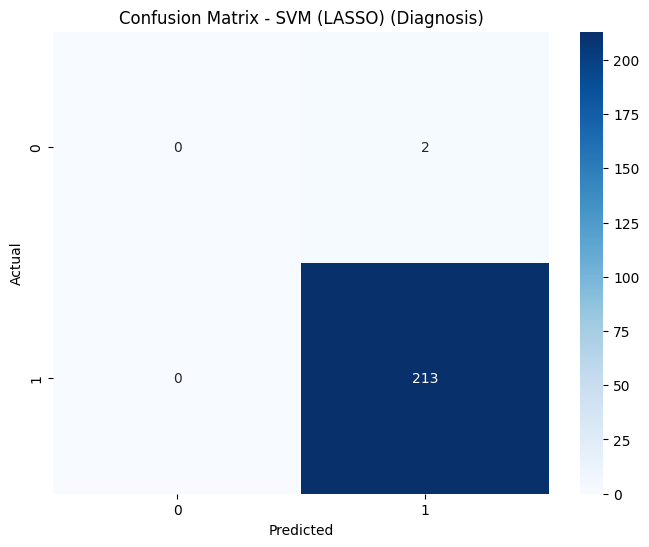


Diagnosis Correlation Matrix saved to ../results/svm/svm_lasso/svm_lasso_diagnosis_correlation_matrix.png


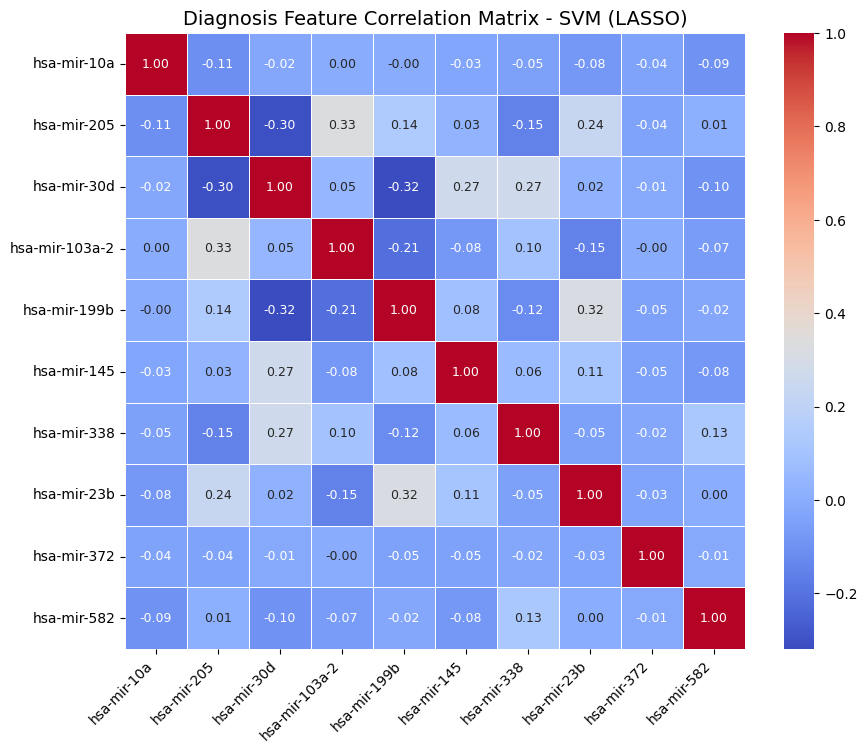


Diagnosis Covariance Matrix saved to ../results/svm/svm_lasso/svm_lasso_diagnosis_covariance_matrix.png


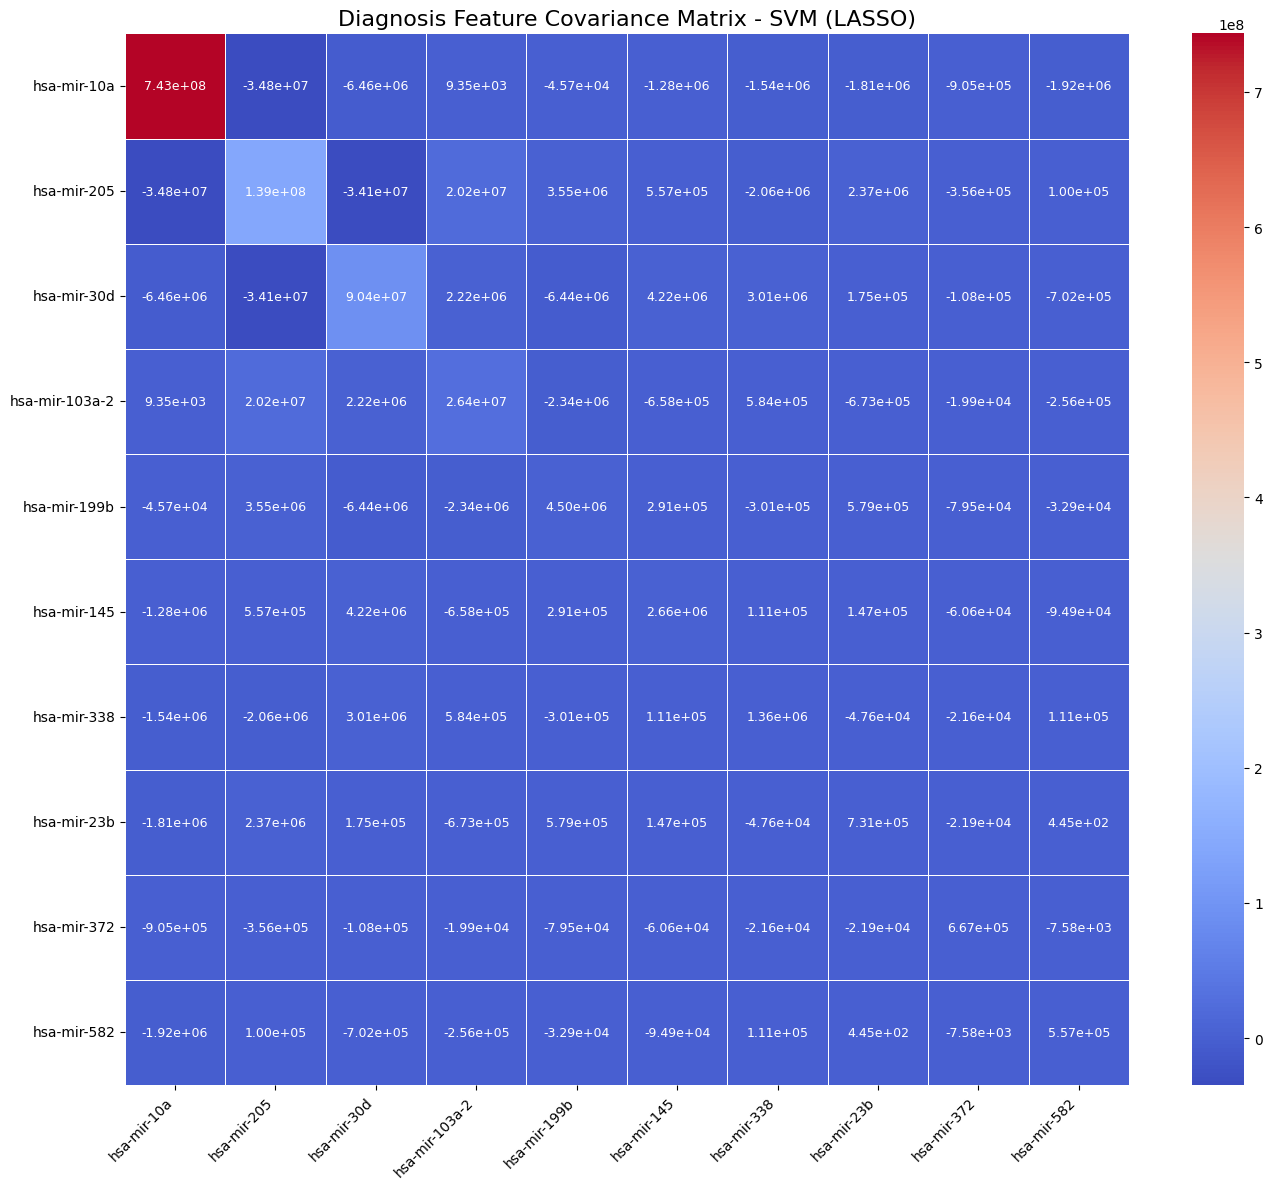


-------------------- SVM_Stage Results --------------------

Accuracy: 0.5209
Sensitivity (Recall): 0.2000
Specificity: 0.5209

Confusion Matrix:
 [[  0   2   0   0   0]
 [  0 112   0   0   0]
 [  0  62   0   0   0]
 [  0  34   0   0   0]
 [  0   5   0   0   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.52      1.00      0.69       112
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00         5

    accuracy                           0.52       215
   macro avg       0.10      0.20      0.14       215
weighted avg       0.27      0.52      0.36       215


Confusion matrix saved to ../results/svm/svm_lasso/svm_lasso_stage_confusion_matrix.png


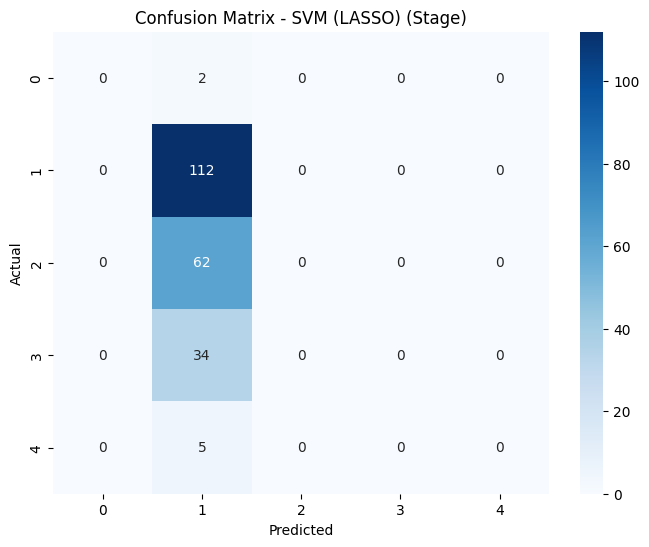


Stage Correlation Matrix saved to ../results/svm/svm_lasso/svm_lasso_stage_correlation_matrix.png


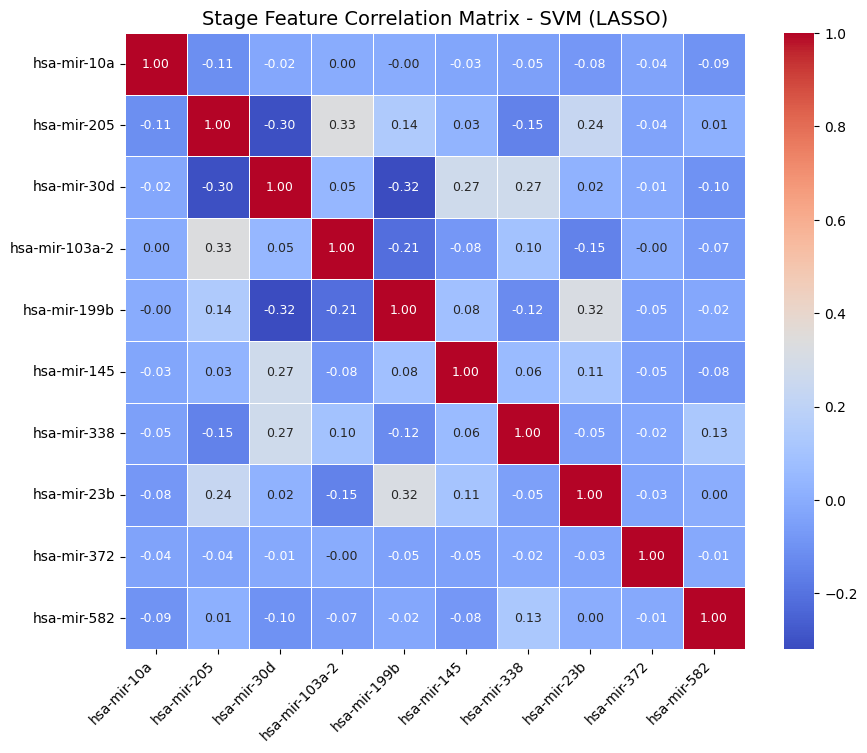


Stage Covariance Matrix saved to ../results/svm/svm_lasso/svm_lasso_stage_covariance_matrix.png


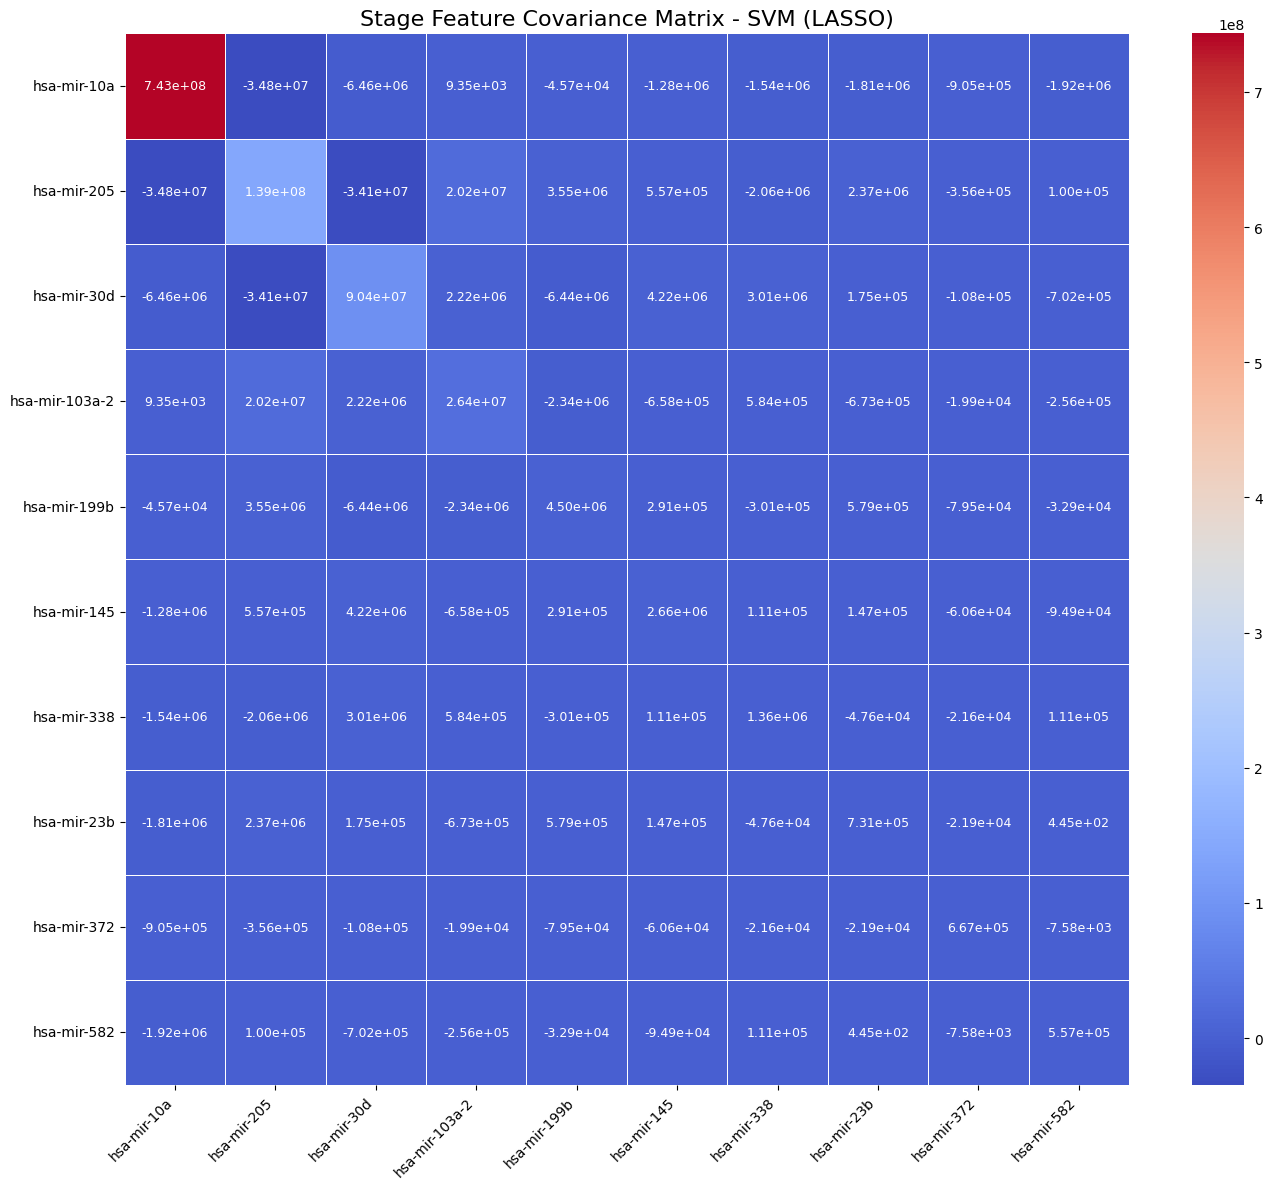


-------------------- SVM_Subtype Results --------------------

Accuracy: 0.4651
Sensitivity (Recall): 0.3093
Specificity: 0.4579

Confusion Matrix:
 [[ 0  1  1]
 [ 0 64 48]
 [ 0 65 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.49      0.57      0.53       112
           2       0.42      0.36      0.39       101

    accuracy                           0.47       215
   macro avg       0.31      0.31      0.31       215
weighted avg       0.46      0.47      0.46       215


Confusion matrix saved to ../results/svm/svm_lasso/svm_lasso_subtype_confusion_matrix.png


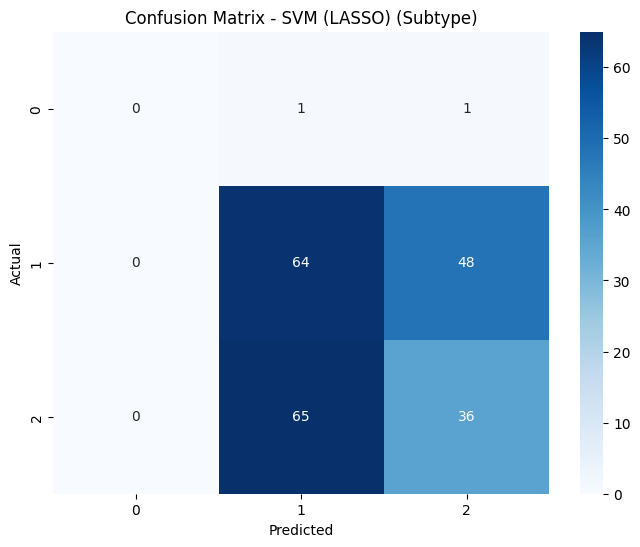


Subtype Correlation Matrix saved to ../results/svm/svm_lasso/svm_lasso_subtype_correlation_matrix.png


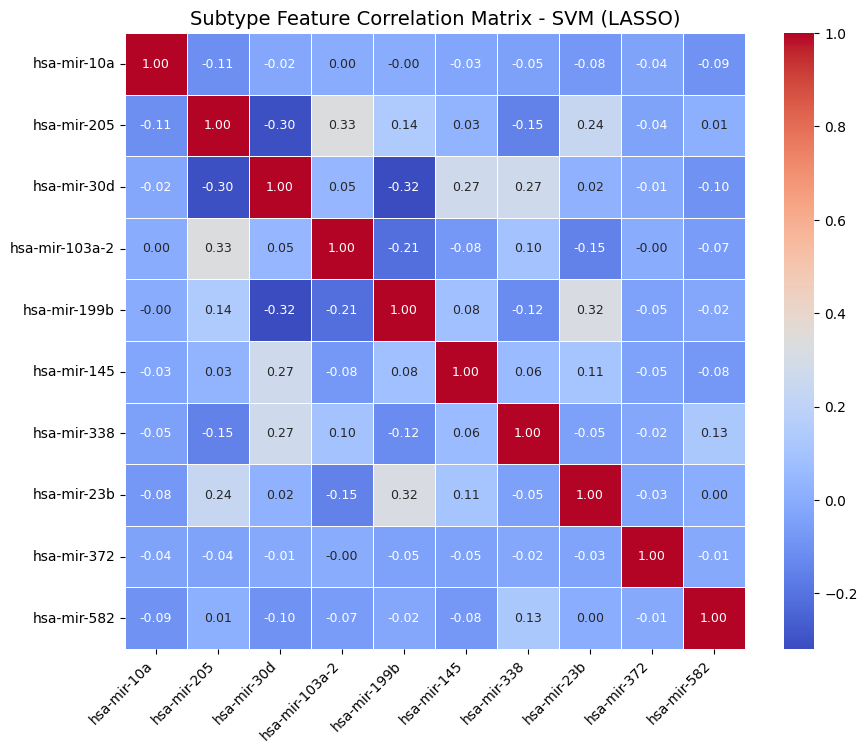


Subtype Covariance Matrix saved to ../results/svm/svm_lasso/svm_lasso_subtype_covariance_matrix.png


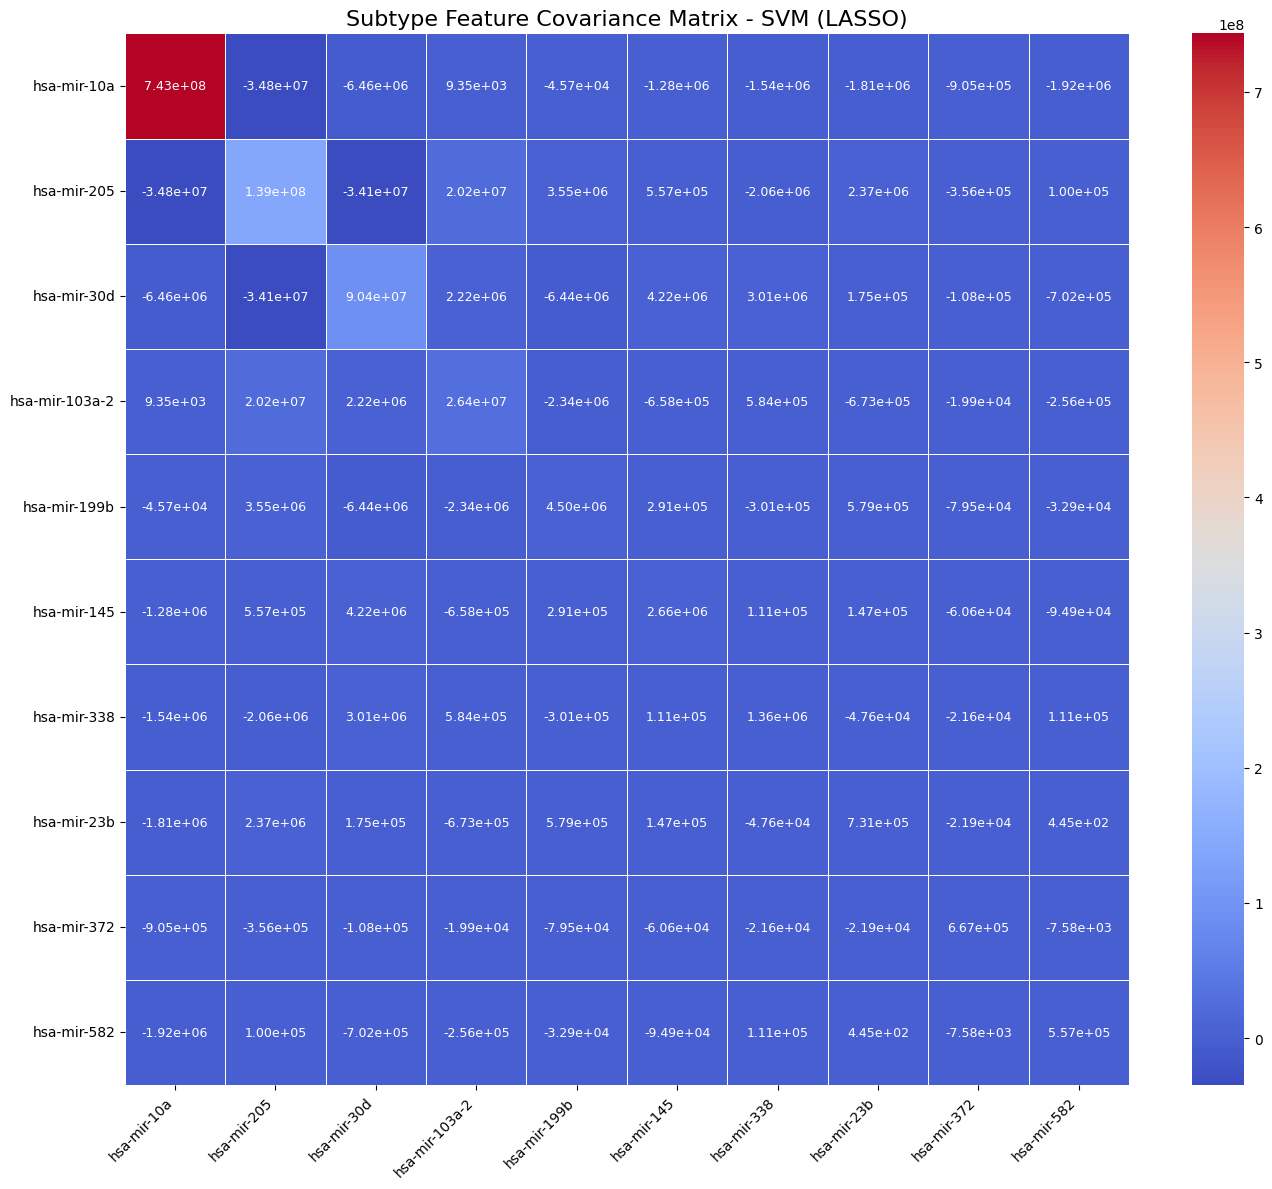


Top 10 Features Based on Maximum Variance:
['hsa-mir-10a', 'hsa-mir-205', 'hsa-mir-30d', 'hsa-mir-103a-2', 'hsa-mir-199b', 'hsa-mir-145', 'hsa-mir-338', 'hsa-mir-23b', 'hsa-mir-372', 'hsa-mir-582']

Top features saved to ../results/svm/svm_lasso/svm_lasso_top_features.txt


In [12]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_multioutput_model(y_test, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (LASSO)", save_dir="../results/svm/svm_lasso/"):
    """
    Evaluate multi-output model performance for Diagnosis, Stage, and Subtype,
    including classification reports, confusion matrices, correlation, and covariance analysis.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Ensure y_test and predictions have the same shape
    min_length = min(len(y_test), len(y_pred_diagnosis), len(y_pred_stage), len(y_pred_subtype))
    y_test_aligned = y_test.iloc[:min_length].reset_index(drop=True)
    y_pred_diagnosis = y_pred_diagnosis[:min_length]
    y_pred_stage = y_pred_stage[:min_length]
    y_pred_subtype = y_pred_subtype[:min_length]

    # Convert predictions to DataFrame
    y_pred_df = pd.DataFrame({
        "diagnosis": y_pred_diagnosis,
        "stage": y_pred_stage,
        "subtype": y_pred_subtype
    })

    # Define Function for Sensitivity & Specificity Calculation
    def calculate_metrics(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0  # Avoid NaN
        else:  # Multi-class classification
            recall_values = np.diag(cm) / np.sum(cm, axis=1)
            precision_values = np.diag(cm) / np.sum(cm, axis=0)
            sensitivity = np.nanmean(recall_values)  # Macro-average recall
            specificity = np.nanmean(precision_values)  # Macro-average specificity
        return sensitivity, specificity

    # Evaluate Models
    results = {}
    for label, y_pred, task in zip(
        ["diagnosis", "stage", "subtype"],
        [y_pred_diagnosis, y_pred_stage, y_pred_subtype],
        ["Diagnosis", "Stage", "Subtype"]
    ):
        accuracy = accuracy_score(y_test_aligned[label], y_pred)
        cm = confusion_matrix(y_test_aligned[label], y_pred)
        report = classification_report(y_test_aligned[label], y_pred, zero_division=0)
        sensitivity, specificity = calculate_metrics(y_test_aligned[label], y_pred)

        results[label] = {
            "accuracy": accuracy,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "confusion_matrix": cm,
            "classification_report": report
        }

        # Print results
        print(f"\n-------------------- SVM_{task} Results --------------------\n")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}\n")
        print("Confusion Matrix:\n", cm)
        print("\nClassification Report:\n", report)

        # Save Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} ({task})")

        cm_path = os.path.join(save_dir, f"svm_lasso_{label}_confusion_matrix.png")
        plt.savefig(cm_path, bbox_inches="tight", dpi=300)  # Ensures no labels get cut off
        print(f"\nConfusion matrix saved to {cm_path}")
        plt.show()

        # Save Correlation and Covariance Matrices
        top_variance_features = X_train.var().sort_values(ascending=False).index[:10]  # Use top 10 features
        filtered_corr_matrix = X_train[top_variance_features].corr()
        filtered_cov_matrix = X_train[top_variance_features].cov()

        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            filtered_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            linewidths=0.5, annot_kws={"size": 9}  # Adjusted for better readability
        )
        plt.xticks(fontsize=10, rotation=45, ha="right")
        plt.yticks(fontsize=10)
        plt.title(f"{task} Feature Correlation Matrix - {model_name}", fontsize=14)
        corr_path = os.path.join(save_dir, f"svm_lasso_{label}_correlation_matrix.png")
        plt.savefig(corr_path, bbox_inches="tight", dpi=400)
        print(f"\n{task} Correlation Matrix saved to {corr_path}")
        plt.show()
        
        # Plot covariance matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            filtered_cov_matrix, 
            annot=True, 
            cmap="coolwarm", 
            fmt=".2e",  # Scientific notation with 3 decimal places
            linewidths=0.5,
            annot_kws={"size": 9}  # Adjusted annotation size
        )
        plt.xticks(fontsize=10, rotation=45, ha="right")
        plt.yticks(fontsize=10)
        plt.title(f"{task} Feature Covariance Matrix - {model_name}", fontsize=16)
        plt.tight_layout()
        
        cov_path = os.path.join(save_dir, f"svm_lasso_{label}_covariance_matrix.png")
        plt.savefig(cov_path, bbox_inches="tight", dpi=600)
        print(f"\n{task} Covariance Matrix saved to {cov_path}")
        plt.show()

    # Identify and Save Top 10 Features
    top_10_features = X_train.var().sort_values(ascending=False).index[:10].tolist()
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_10_features)

    top_features_path = os.path.join(save_dir, "svm_lasso_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_10_features:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    return results

# Run Evaluation for LASSO Feature Selection
save_dir = "../results/svm/svm_lasso/"
metrics_lasso = evaluate_multioutput_model(y_test, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (LASSO)", save_dir=save_dir)


### Save Everything & Finalize the Pipeline (Lasso)

In [13]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory for LASSO Results
output_dir = "../results/svm/svm_lasso/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Validate Required Variables Exist
required_variables = ["y_test_stage", "y_test_subtype", "y_pred_stage", "y_pred_subtype"]
for var in required_variables:
    if var not in locals():
        raise ValueError(f"Missing required variable: `{var}`. Ensure it is defined before running this block.")

# Ensure Predictions and Actual Labels Have Matching Lengths
min_length = min(len(y_test_stage), len(y_pred_stage), len(y_pred_subtype))
y_test_stage = y_test_stage.iloc[:min_length].reset_index(drop=True)
y_test_subtype = y_test_subtype.iloc[:min_length].reset_index(drop=True)
y_pred_stage = y_pred_stage[:min_length]
y_pred_subtype = y_pred_subtype[:min_length]

# Save Predictions & Actual Labels
predictions_df = pd.DataFrame({
    "predicted_stage": y_pred_stage,
    "predicted_subtype": y_pred_subtype
}, index=y_test_stage.index)

predictions_path = os.path.join(output_dir, "svm_lasso_predictions.csv")
predictions_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_df = pd.DataFrame({
    "actual_stage": y_test_stage,
    "actual_subtype": y_test_subtype
})
actual_labels_path = os.path.join(output_dir, "svm_lasso_actual_labels.csv")
actual_labels_df.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "stage_hyperparameters": grid_stage.best_params_ if "grid_stage" in locals() else "N/A",
    "subtype_hyperparameters": grid_subtype.best_params_ if "grid_subtype" in locals() else "N/A",
    "stage_accuracy": metrics["stage_accuracy"] if "metrics" in locals() and "stage_accuracy" in metrics else "N/A",
    "subtype_accuracy": metrics["subtype_accuracy"] if "metrics" in locals() and "subtype_accuracy" in metrics else "N/A",
    "stage_confusion_matrix": metrics["stage_confusion_matrix"] if "metrics" in locals() and "stage_confusion_matrix" in metrics else "N/A",
    "subtype_confusion_matrix": metrics["subtype_confusion_matrix"] if "metrics" in locals() and "subtype_confusion_matrix" in metrics else "N/A",
    "train_set_size": X_train.shape[0] if "X_train" in locals() else "N/A",
    "test_set_size": X_test.shape[0] if "X_test" in locals() else "N/A"
}

metadata_path = os.path.join(output_dir, "svm_lasso_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Separate Models for Stage & Subtype (Only if Available)
if "best_svm_stage" in locals():
    model_stage_path = os.path.join(output_dir, "svm_lasso_stage_model.pkl")
    joblib.dump(best_svm_stage, model_stage_path)
    logging.info(f"Stage model saved to {model_stage_path}")
    print(f"Stage model saved to {model_stage_path}")
else:
    logging.warning("`best_svm_stage` is missing. The model was not saved.")

if "best_svm_subtype" in locals():
    model_subtype_path = os.path.join(output_dir, "svm_lasso_subtype_model.pkl")
    joblib.dump(best_svm_subtype, model_subtype_path)
    logging.info(f"Subtype model saved to {model_subtype_path}")
    print(f"Subtype model saved to {model_subtype_path}")
else:
    logging.warning("`best_svm_subtype` is missing. The model was not saved.")

print("\nAll results successfully saved. The SVM pipeline using LASSO features is complete.")

2025-03-09 17:42:01,846 - INFO - Predictions saved to ../results/svm/svm_lasso/svm_lasso_predictions.csv
2025-03-09 17:42:01,849 - INFO - Actual labels saved to ../results/svm/svm_lasso/svm_lasso_actual_labels.csv
2025-03-09 17:42:01,850 - INFO - Metadata saved to ../results/svm/svm_lasso/svm_lasso_metadata.json
2025-03-09 17:42:01,856 - INFO - Stage model saved to ../results/svm/svm_lasso/svm_lasso_stage_model.pkl
2025-03-09 17:42:01,864 - INFO - Subtype model saved to ../results/svm/svm_lasso/svm_lasso_subtype_model.pkl


Predictions saved to ../results/svm/svm_lasso/svm_lasso_predictions.csv
Actual labels saved to ../results/svm/svm_lasso/svm_lasso_actual_labels.csv
Metadata saved to ../results/svm/svm_lasso/svm_lasso_metadata.json
Stage model saved to ../results/svm/svm_lasso/svm_lasso_stage_model.pkl
Subtype model saved to ../results/svm/svm_lasso/svm_lasso_subtype_model.pkl

All results successfully saved. The SVM pipeline using LASSO features is complete.
